# Reconocimiento de acciones humanas

Comparar arquitecturas RNN y CNN para reconocimiento de acciones humanas en el conjunto UCF11. La solución debe cumplir con los siguientes puntos:
* Usar las características convolucionales vistas en clase (dataset: https://cloud.xibalba.com.mx/s/QwapfBYpYNmNbPP)
* Implementar una arquitectura RNN bidireccional con una capa GRU.
* Implementar una arquitectura CNN con una capa Conv1d.
* Modificar el tamaño de las capas para que ambos modelos tengan un número similar de parámetros.
* Discutir el comportamiento durante el entrenamiento y resultados finales en ambos conjuntos.

<a href="https://colab.research.google.com/drive/1O9aqK_GZ5Pb0i6PofOI6vuVx29GvLJLb?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-summary
!pip install zarr

In [2]:
#importamos librerias utiles 
#deep learning
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optimizerr
import torchvision.datasets.utils as tutils
import torchvision.datasets as DataSets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision.models as torchModels
from torch.utils.tensorboard import SummaryWriter
#matrices y matematicas
import numpy as np
import pandas as pd
# tomar n elementos de una secuencia
from itertools import islice as take
#imagenes
from matplotlib import pyplot as plt
#arreglos multidimensionales
import zarr
#descarga de archivos
import wget
#para acceder a ficheros del sistema
import os
import glob
#para descomprimir el archivo UTKFace.tar.gz
import tarfile
# barra de progreso
from tqdm import trange
#para reproducibilidad
import random
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [3]:
#para usar la GPU si esta disponible
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"

device = torch.device(dev)
print('Usando {}'.format(device))

Usando cuda:0


### UCF 11: Youtube Action Data Set
contiene 11 cantegorias de acciones humanas: basketball shooting, biking or cycling, diving, golf swinging, horse back riding, soccer juggling, swinging, trampoline jumping, volleyball spiking and walking with a dog

## Carga del dataset en pytorch

In [4]:
class UCF11(Dataset):
    #funcion instanciadora
    def __init__(self, directory, download = False):
        #definimos variable "global" de la clase
        self.directory = directory
        #definimos el directorio donde estaran los datos, tambien es variable "global"
        self.zarrDirectory = os.path.join(self.directory, 'ucf11.zarr')
        #si download=True
        if download:
            #aplica el metodo downloadDataset
            self.downloadDataset()
        #define variable para abrir el los archivos .zarr
        self.zar = zarr.open(self.zarrDirectory, 'r')
        #lista los directorios contenidos dentro del directorio
        self.paths = list(self.zar.array_keys())
    #metodo para extraer items del dataset        
    def __getitem__(self, idx):
        #extrae un elemento contenida dentro del directorio paths con id idx
        array = self.zar[self.paths[idx]]
        #convierte a matriz el elemento extraido
        x = np.array(array)
        #extrae su etiqueta
        y = np.array(array.attrs['y'], dtype = np.int64)
        #regresa la matriz y su etiqueta
        return x , y
    #metodo para extraer la cantidad de datos en dataset
    def __len__(self):
        return len(self.paths)
    #metodo para descargar los datos
    def downloadDataset(self):
        #funcioon de pytorch que permite descargar los datos
        tutils.download_and_extract_archive(
            #url de los datos
            url = 'http://cloud.xibalba.com.mx/s/QwapfBYpYNmNbPP/download',
            #ruta donde se guardan los datos
            download_root = self.directory,
            #nombre del archivo a descargar
            filename = 'ucf11.zarr.tar.gz'
        )

### Instanciando el dataset

In [5]:
dataset = UCF11('dataUCF', True)
print('El dataset consta de {} muestras'.format(len(dataset)))
sampleX , sampleY = dataset[499]
print('Los datos "duros" son matrices de dimensiones {}'.format(sampleX.shape))
print('Las clases son enteros')
#limpiamos las variables
sampleX, sampleY = None, None

Using downloaded and verified file: dataUCF\ucf11.zarr.tar.gz
Extracting dataUCF\ucf11.zarr.tar.gz to dataUCF
El dataset consta de 1599 muestras
Los datos "duros" son matrices de dimensiones (10, 1024)
Las clases son enteros


### Conjuntos de entrenamiento y prueba

In [6]:
#definimos el tamaño de los conjuntos de prueba y entrenamiento
trainSize = int(0.8 * len(dataset))
testSize = int(len(dataset) - trainSize)
#hacemos un print para verificar que no se quedaron datos sin asignar
print('La suma de los enteros trainSize y testSize es {}'.format(testSize+trainSize))
#instanciamos los datasets de entrenamiento y prueba a partir del deataset general shufleado
train, test = random_split(dataset, [trainSize ,testSize])
#hacemos un print para verificar que no se quedaron datos sin asignar
print('La suma de la longitud de train y test es {}'.format(len(test)+len(train)))

La suma de los enteros trainSize y testSize es 1599
La suma de la longitud de train y test es 1599


### Cargando datos

In [7]:
#creamos el cargador de datos de entrenamiento con un tamaño de lote de 64, se hace shuffle.
#no usar otro numero de num_workers de cero porque si no no jala ¿Error de pytorch?
trainLoader = DataLoader(train, batch_size=32, shuffle = True, num_workers=0)
#creamos el cargador de datos de prueba con un tamaño de lote de 64, se hace shuffle.
#no usar otro numero de num_workers de cero porque si no no jala ¿Error de pytorch?
testLoader = DataLoader(test, batch_size=32, shuffle = True, num_workers=0)

#verificamos que los datos se hayan cargado correctamente
x, y = next(iter(trainLoader))
print(f'x de train shape={x.shape} dtype={x.dtype}')
print(f'y de train shape={y.shape} dtype={y.dtype}')
x, y = next(iter(testLoader))
print(f'x de test shape={x.shape} dtype={x.dtype}')
print(f'y de test shape={y.shape} dtype={y.dtype}')

x de train shape=torch.Size([32, 10, 1024]) dtype=torch.float32
y de train shape=torch.Size([32]) dtype=torch.int64
x de test shape=torch.Size([32, 10, 1024]) dtype=torch.float32
y de test shape=torch.Size([32]) dtype=torch.int64


## Definición de la arquitectura RNN-GRU bidireccional

In [8]:
#creamos la clase RNN
class RNN(nn.Module):
    #metodo instanciador, inputSize: longitud de la entrada x. hiddenSize: tamaño
    #de las caracteristicas del estado oculto h.
    def __init__(self, inputSize=1024, hiddenSize = 128, numClasses = 11):
        #instanciamos a la clase padre RNN de pytorch
        super(RNN, self).__init__()
        #definimos nuestra capa de normalizacion por lotes
        self.batchNorm = nn.BatchNorm1d(inputSize)
        #definimos la capa recurrente GRU bidireccional (bidireccional=True)
        self.recurrentNN = nn.GRU(input_size=inputSize, hidden_size = hiddenSize, num_layers = 1, 
                                  batch_first=True, bidirectional=True)
        #La capa GRU bidireccional escupe un vector de longitud 2 veces el tamaño del estado oculto
        #definimos nuestra capa lineal que recibe un vector de longitud 2 veces el estado oculto
        self.classifierN = nn.Linear(2*hiddenSize, numClasses)
    #propagacion    
    def forward(self, x):
        #Los datos vienen como [batch, secuencia, caracteristicas] los permutamos a
        # [batch, caract, secuencia] para pasarlos por el batchNorm
        x = x.permute(0, 2, 1)
        #batchnorm
        x = self.batchNorm(x)
        #repermutamos al estado original
        x = x.permute(0, 2, 1)
        #RNN escupe la salida out y el estado oculto h_n
        x, h = self.recurrentNN(x)
        #tiramos a la basura h porque no hay otras RNN conectadas a esta.
        #calculamos la media de las salidas (x)
        x = torch.mean(x,1)
        #clasificador
        x = self.classifierN(x)
        #regresa la clasificacion
        return x

In [9]:
#instanciamos nuestro modelo RNN-GRU bidireccional
modelRNN = RNN()
#pasamos nuestro modelo al device
modelRNN = modelRNN.to(device)
#imprimimos el summary del modelo
summary(modelRNN, (10, 1024), device = device, verbose = 0)

Layer (type:depth-idx)                   Output Shape              Param #
├─BatchNorm1d: 1-1                       [-1, 1024, 10]            2,048
├─GRU: 1-2                               [-1, 10, 256]             886,272
├─Linear: 1-3                            [-1, 11]                  2,827
Total params: 891,147
Trainable params: 891,147
Non-trainable params: 0
Total mult-adds (M): 0.89
Input size (MB): 0.04
Forward/backward pass size (MB): 0.10
Params size (MB): 3.40
Estimated Total Size (MB): 3.54

## Definición de la arquitectura convolucional

In [10]:
#creamos una clase de un solo bloque convolucional 1d
class ConvBlock(nn.Module):
    #definimos su metodo instanciador, este metodo permite seleccionar el tamaño del
    #kernel, padding de la conv1d y el tipo de maxpoll1d (avg o max) kernel y pading fijos
    def __init__(self, inChannels, outChannels, kernelSize, padding, MaxPool = True):
        #instanciamos a la clase padre CNN de pytorch
        super(ConvBlock, self).__init__()
        #definimos el bloque convolucional como una secuencial
        self.ConvNN = nn.Sequential(
            #aplicamos la convolucion1d con los parametros del metodo
            nn.Conv1d(in_channels = inChannels, out_channels = outChannels,
                      kernel_size = kernelSize, padding = padding),
            #aplicamos una funcion de activación relu que es nuestro caballo de batalla
            nn.ReLU(),
            #aplicamos maxpol1d si MaxPool=True, en otro caso aplicamos un AvgPool1d
            nn.MaxPool1d(kernel_size = 2, stride = 2) if MaxPool else nn.AvgPool1d(2,2),
        )
    #funcion propagadora
    def forward(self,x):
        #propaga la capa convolucional
        x = self.ConvNN(x)
        #este print es para realizar debug sobre el modelo
        #print(x.shape)
        #regresa el resultado de aplicar el bloque convolucional
        return x

In [11]:
#define el modelo CNN
class CNN(nn.Module):
    #metodo instanciador
    def __init__(self):
        #llamamos a la clase padre de pytorch
        super(CNN, self).__init__()
        self.batchNorm = nn.BatchNorm1d(1024)
        #aplicamos nuestras convoluciones con un secuencial, esto fue definido para
        #cumplir el requerimiento de crear una red CNN con los mismos parametros
        #fue a prueba y error
        self.cnn = nn.Sequential(
            #aplica un bloque convolucional con entrada 10, salida 50, kernel de 2, padding de 1
            #con un Avgpooling
            ConvBlock(inChannels=1024, outChannels = 256, kernelSize = 2, padding=1, MaxPool=False),
            #aplica un bloque convolucional con entrada 50, salida 150, kernel de 2, padding de 1
            #con un Avgpooling
            ConvBlock(inChannels=256, outChannels = 150, kernelSize = 2, padding=1, MaxPool=False),
            #aplica un bloque convolucional con entrada 150, salida 200, kernel de 3, padding de 2
            #con un maxpooling
            ConvBlock(inChannels=150, outChannels = 200, kernelSize = 3, padding=2, MaxPool=True),
            #aplica un bloque convolucional con entrada 200, salida 300, kernel de 3, padding de 2
            #con un maxpooling
            ConvBlock(inChannels=200, outChannels = 300, kernelSize = 3, padding=2, MaxPool=True),
        )
        #aplasta la salida del conjunto de bloques convolucionales
        self.flatten = nn.Flatten()
        #Sequential de classificacion
        self.classifier = nn.Sequential(
            #define una fully connected de entrada 19500 y salida 31
            nn.Linear(600, 31),
            #aplica una ReLU a la salida de la fully connected
            nn.ReLU(),
            #fully connected con salida igual a las clases para clasificacion
            nn.Linear(31,11),   
        )
    #metodo de propagacion    
    def forward(self, x):
        #Los datos vienen como [batch, secuencia, caracteristicas] los permutamos a
        # [batch, caract, secuencia] para pasarlos por el batchNorm y los cloques convoluacionales
        x = x.permute(0, 2, 1)
        #batchnorm
        x = self.batchNorm(x)
        #print para hacer debug
        #print(x.shape)
        #aplica bloques convolucionales
        x = self.cnn(x)
        #print para hacer debug
        #print(x.shape)
        #aplasta la salida de los bloques convolucionales
        x = self.flatten(x)
        #print para hacer debug
        #print(x.shape)
        #Fully connected para clasificacion
        x = self.classifier(x)
        return x

In [12]:
#instanciamos nuestro modelo RNN-GRU bidireccional
modelCNN = CNN()
#pasamos nuestro modelo al device
modelCNN = modelCNN.to(device)
#imprimimos el summary del modelo
summary(modelCNN, (10, 1024), device = device, verbose = 0)

Layer (type:depth-idx)                   Output Shape              Param #
├─BatchNorm1d: 1-1                       [-1, 1024, 10]            2,048
├─Sequential: 1-2                        [-1, 300, 2]              --
|    └─ConvBlock: 2-1                    [-1, 256, 5]              --
|    |    └─Sequential: 3-1              [-1, 256, 5]              524,544
|    └─ConvBlock: 2-2                    [-1, 150, 3]              --
|    |    └─Sequential: 3-2              [-1, 150, 3]              76,950
|    └─ConvBlock: 2-3                    [-1, 200, 2]              --
|    |    └─Sequential: 3-3              [-1, 200, 2]              90,200
|    └─ConvBlock: 2-4                    [-1, 300, 2]              --
|    |    └─Sequential: 3-4              [-1, 300, 2]              180,300
├─Flatten: 1-3                           [-1, 600]                 --
├─Sequential: 1-4                        [-1, 11]                  --
|    └─Linear: 2-5                       [-1, 31]               

In [13]:
modelCNN

CNN(
  (batchNorm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn): Sequential(
    (0): ConvBlock(
      (ConvNN): Sequential(
        (0): Conv1d(1024, 256, kernel_size=(2,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
      )
    )
    (1): ConvBlock(
      (ConvNN): Sequential(
        (0): Conv1d(256, 150, kernel_size=(2,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
      )
    )
    (2): ConvBlock(
      (ConvNN): Sequential(
        (0): Conv1d(150, 200, kernel_size=(3,), stride=(1,), padding=(2,))
        (1): ReLU()
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (3): ConvBlock(
      (ConvNN): Sequential(
        (0): Conv1d(200, 300, kernel_size=(3,), stride=(1,), padding=(2,))
        (1): ReLU()
        (2): MaxPool1d(kernel_size=2, 

## Funcion para entrenar

In [14]:
#funcion para entrenar determinado numero de epocas
def trainData(model, epochs, dataTrain, dataTest):
    #reproducibilidad
    torch.manual_seed(2021)
    #creamos listas para guardar la perdida y exactitud de cada epoca
    perdida = []
    exactitud = []
    #pasamos el modelo a la gpu (si hay, si no al cpu)
    model.to(device, non_blocking=True)
    #definimos el optimizador
    optimizer = optimizerr.Adam(model.parameters(), lr=3e-4)
    #ciclo de entrenamiento
    for epoch in range(epochs):
        model.train()
        #entrena una epoca
        for x, y in dataTrain:
            #pasamos los tensores a la gpu (si hay, si no al cpu)
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            #inferencia para obtener logits
            logits = model(x)
            #calculamos la perdida
            loss = func.cross_entropy(logits, y)
            #vaciamos gradientes
            optimizer.zero_grad()
            #retropropagacion
            loss.backward()
            #actualiza parametros
            optimizer.step()
        #desactivamos la modificacion de parametros para evaluar    
        with torch.no_grad():
            #modelo en modo de evaluacion
            model.eval()
            #listas para cacular la perdida el el accuracy de la epoca
            losses, accs = [], []
            #validamos la epoca
            for x, y in dataTest:
                #pasamos los tensores a la gpu (si hay, si no al cpu)
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                #calculamos logits
                logits = model(x)
                #calculamos la probabilidad de cada clase
                proba = func.softmax(logits, 1)
                #obtenemos la clase predicha
                predicted = torch.argmax(proba, 1)
                #calculamos la perdida
                loss = func.cross_entropy(logits, y)
                #calculamos el accuracy
                acc = (y == predicted).type(torch.float32).mean()
                #guardamos los valores de loss y acc
                losses.append(loss.item() * 100)
                accs.append(acc.item() * 100)
            #imprimimos metricas
            loss = np.mean(losses)
            acc = np.mean(accs)
            print(f'Epoca {epoch:2},  Perdida={loss:6.2f},  acc={acc:0.2f}')
            #guardamos en las listas las metricas de cada epoca
            perdida.append(loss)
            exactitud.append(acc)
    return perdida, exactitud

In [15]:
lossRNN, accRNN = trainData(modelRNN, epochs=80, dataTrain=trainLoader, dataTest = testLoader)

Epoca  0,  Perdida=215.35,  acc=30.94
Epoca  1,  Perdida=195.30,  acc=37.19
Epoca  2,  Perdida=181.78,  acc=37.81
Epoca  3,  Perdida=173.39,  acc=45.94
Epoca  4,  Perdida=166.45,  acc=47.19
Epoca  5,  Perdida=160.72,  acc=47.81
Epoca  6,  Perdida=155.31,  acc=48.12
Epoca  7,  Perdida=151.63,  acc=50.00
Epoca  8,  Perdida=146.65,  acc=52.19
Epoca  9,  Perdida=142.32,  acc=52.81
Epoca 10,  Perdida=142.40,  acc=53.75
Epoca 11,  Perdida=139.85,  acc=55.31
Epoca 12,  Perdida=135.64,  acc=54.69
Epoca 13,  Perdida=134.12,  acc=57.19
Epoca 14,  Perdida=133.47,  acc=55.00
Epoca 15,  Perdida=131.31,  acc=55.62
Epoca 16,  Perdida=134.13,  acc=55.94
Epoca 17,  Perdida=135.12,  acc=56.88
Epoca 18,  Perdida=135.66,  acc=56.88
Epoca 19,  Perdida=137.45,  acc=56.88
Epoca 20,  Perdida=137.47,  acc=57.19
Epoca 21,  Perdida=137.78,  acc=58.12
Epoca 22,  Perdida=137.16,  acc=57.81
Epoca 23,  Perdida=146.24,  acc=56.56
Epoca 24,  Perdida=141.00,  acc=57.81
Epoca 25,  Perdida=146.91,  acc=57.19
Epoca 26,  P

In [16]:
lossCNN, accCNN = trainData(modelCNN, epochs=80, dataTrain=trainLoader, dataTest = testLoader)

Epoca  0,  Perdida=232.99,  acc=16.56
Epoca  1,  Perdida=220.85,  acc=25.62
Epoca  2,  Perdida=209.97,  acc=28.44
Epoca  3,  Perdida=190.67,  acc=31.88
Epoca  4,  Perdida=182.14,  acc=38.44
Epoca  5,  Perdida=174.82,  acc=43.75
Epoca  6,  Perdida=175.73,  acc=46.25
Epoca  7,  Perdida=168.04,  acc=47.50
Epoca  8,  Perdida=180.47,  acc=49.06
Epoca  9,  Perdida=184.84,  acc=50.94
Epoca 10,  Perdida=183.34,  acc=45.31
Epoca 11,  Perdida=186.05,  acc=50.62
Epoca 12,  Perdida=176.86,  acc=56.56
Epoca 13,  Perdida=217.50,  acc=47.50
Epoca 14,  Perdida=185.73,  acc=56.25
Epoca 15,  Perdida=196.28,  acc=54.38
Epoca 16,  Perdida=229.21,  acc=49.06
Epoca 17,  Perdida=212.01,  acc=53.75
Epoca 18,  Perdida=211.92,  acc=57.19
Epoca 19,  Perdida=220.72,  acc=55.62
Epoca 20,  Perdida=252.06,  acc=53.75
Epoca 21,  Perdida=241.95,  acc=55.62
Epoca 22,  Perdida=238.23,  acc=50.94
Epoca 23,  Perdida=252.74,  acc=55.31
Epoca 24,  Perdida=255.30,  acc=55.31
Epoca 25,  Perdida=288.12,  acc=46.88
Epoca 26,  P

In [17]:
## Creamos una funcion que grafica los datos de accuracy en entrenamiento:
def graficaAcc(accurac):
    plt.plot(np.arange(len(accurac)), accurac, '--', label='Accuracy', color = 'red')
    plt.legend()
    plt.xlabel('Epocas')
    plt.ylabel('Accuracy Entrenamiento')
    plt.grid(True)
    plt.show()
    
## Creamos una funcion que grafica los datos de la perdida en entrenamiento:
def graficaLoss(perdidas):
    plt.plot(np.arange(len(perdidas)), perdidas, '--', label='Perdida', color = 'blue')
    plt.legend()
    plt.xlabel('Epocas')
    plt.ylabel('Perdida Entrenamiento')
    plt.grid(True)
    plt.show()

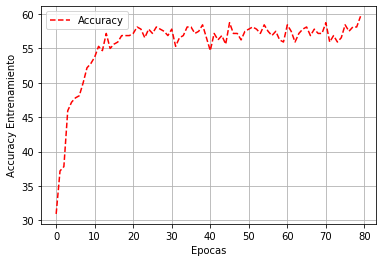

In [18]:
#graficamos acurracy de la RNN
graficaAcc(accRNN)

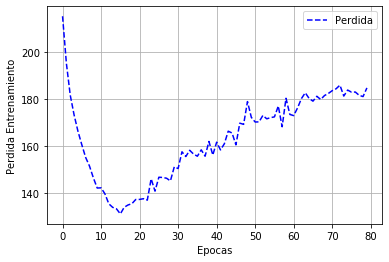

In [19]:
#graficamos la perdida de la RNN
graficaLoss(lossRNN)

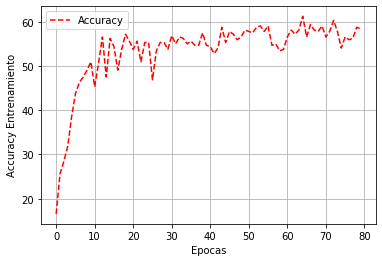

In [20]:
#graficamos acurracy de la CNN
graficaAcc(accCNN)

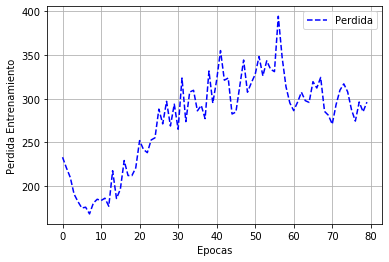

In [21]:
#graficamos la perdida de la CNN
graficaLoss(lossCNN)

# Discusión

Aparentemente el modelo RNN con capa GRU entrena ligeramente más rápido que el modelo CNN, esto puede deberse a que el CNN tiene aproximadamente 2 mil parametros entrenables más. Ambos modelos entrenados por 80 epocas terminan con un accuracy muy similar. 60% para RNN y 58.4% para el CNN. De las graficas de accuracy vemos que el modelo de RNN "converge" más rápido con respecto al CNN. Así mismo el accuracy es menos ruidoso para la RNN.
Para ambos modelos la perdida tiende a incrementar a lo largo de las epocas, sin embargo, esto no tiene interpretación alguna.
Finalmente, vemos que el accuraccy para ambos modelos es muy bajo a lo esperado a pesar de usar 80 epocas de entrenamiento. Esto puede deberse a que la cantidad de datos empleados es muy pequeña (1599) como para que al menos un modelo pueda generalizar las caracteristicas objetivo. De una manera similar, dado que el dataset viene como una matriz y no como imagenes no sabemos si el dataset está bien balanceado. Si el dataset está muy desbalanceado, es claro que el accuracy será bajo en algunos casos. Si el data set está balanceado podemos usar el argumento de los datos pequeños.
El modelo de la CNN se contruyó a modo de intentar emular la RNN, de alguna manera. Este hecho a parentemente pudo lograrse con una gran cantidad de bloques convolucionales y variando los maxpooling. Aún cuando se alcanzó un accuracy similar en ambos casos no es posible conocer el poder expresivo de los mismos, que quizá alguno de ellos sea más expresivo para esta tarea.